In [126]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPool2D,AveragePooling2D,Dropout,Activation,Input,Concatenate,Add,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [233]:

def resolution_block(input_layer,n_convs,filters,kernel_size,padding = 'same',kernel_initializer = 'glorot_uniform',
                     batch_norm = False,dropout = None,activation = 'relu',add = True,strides = 1,name = '_'):
    '''
    Create a fully convolutional block with parameters
    inputs :
        n_convs : number of convolutional layers
        
    outputs:
        convs : 
    '''
    x = input_layer
    for i in range(n_convs):
        x = Conv2D(filters= filters,
                   kernel_size = kernel_size ,
                   strides= strides,
                   padding=padding,
                   kernel_initializer=kernel_initializer,
                   #name = 'conv_'+str(i+1)+ '_' + name
                   )(x)
        if batch_norm :
            x = BatchNormalization()(x)
        x = Activation(activation)(x)  
    if dropout : 
        x = Dropout(dropout)(x)
    
    if add :
        x = Add()([input_layer,x])
        x = Activation('relu')(x)
    
    return x


def create_n_blocks(n ,*args,**kwargs):
    x = args[0]
    for i in range (n):
        x = resolution_block(x,*args[1:],**kwargs)
    return x


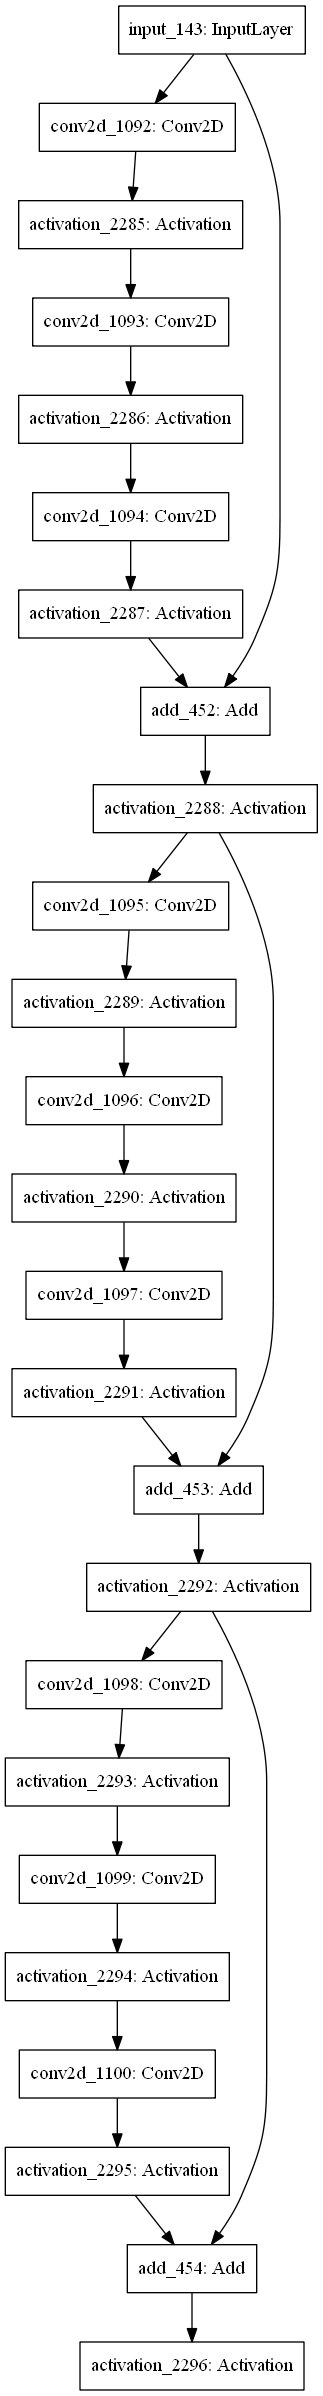

In [234]:
input_layer = Input(shape = (256,256,32))
x = input_layer
#for i in range(3):
   #x =  resolution_block(input_layer=x,n_convs = 3,filters=32,kernel_size=3,name = 'res_256')
output = create_n_blocks(3,x,3,32,3,name = 'res_256')
model = Model(inputs = input_layer,outputs= [output])
plot_model(model)

In [212]:
def trial(x = 3):
    return 'hey'

def ff(*args,**kwargs):
    return args,kwargs

x, y = ff(4,2,1,keys = 3)

x[1:]

(2, 1)

In [141]:
def transition_up(input_layer,filters,target_size=0,batch_norm = False,activation = 'relu'):
    
    x = input_layer
    size = input_layer.shape[1]
    ratio = target_size/size
    x = UpSampling2D(size = int(ratio))(x)
    x = Conv2D(filters=filters,kernel_size=(1,1),padding = 'same')(x)
    if batch_norm :
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    return x


    

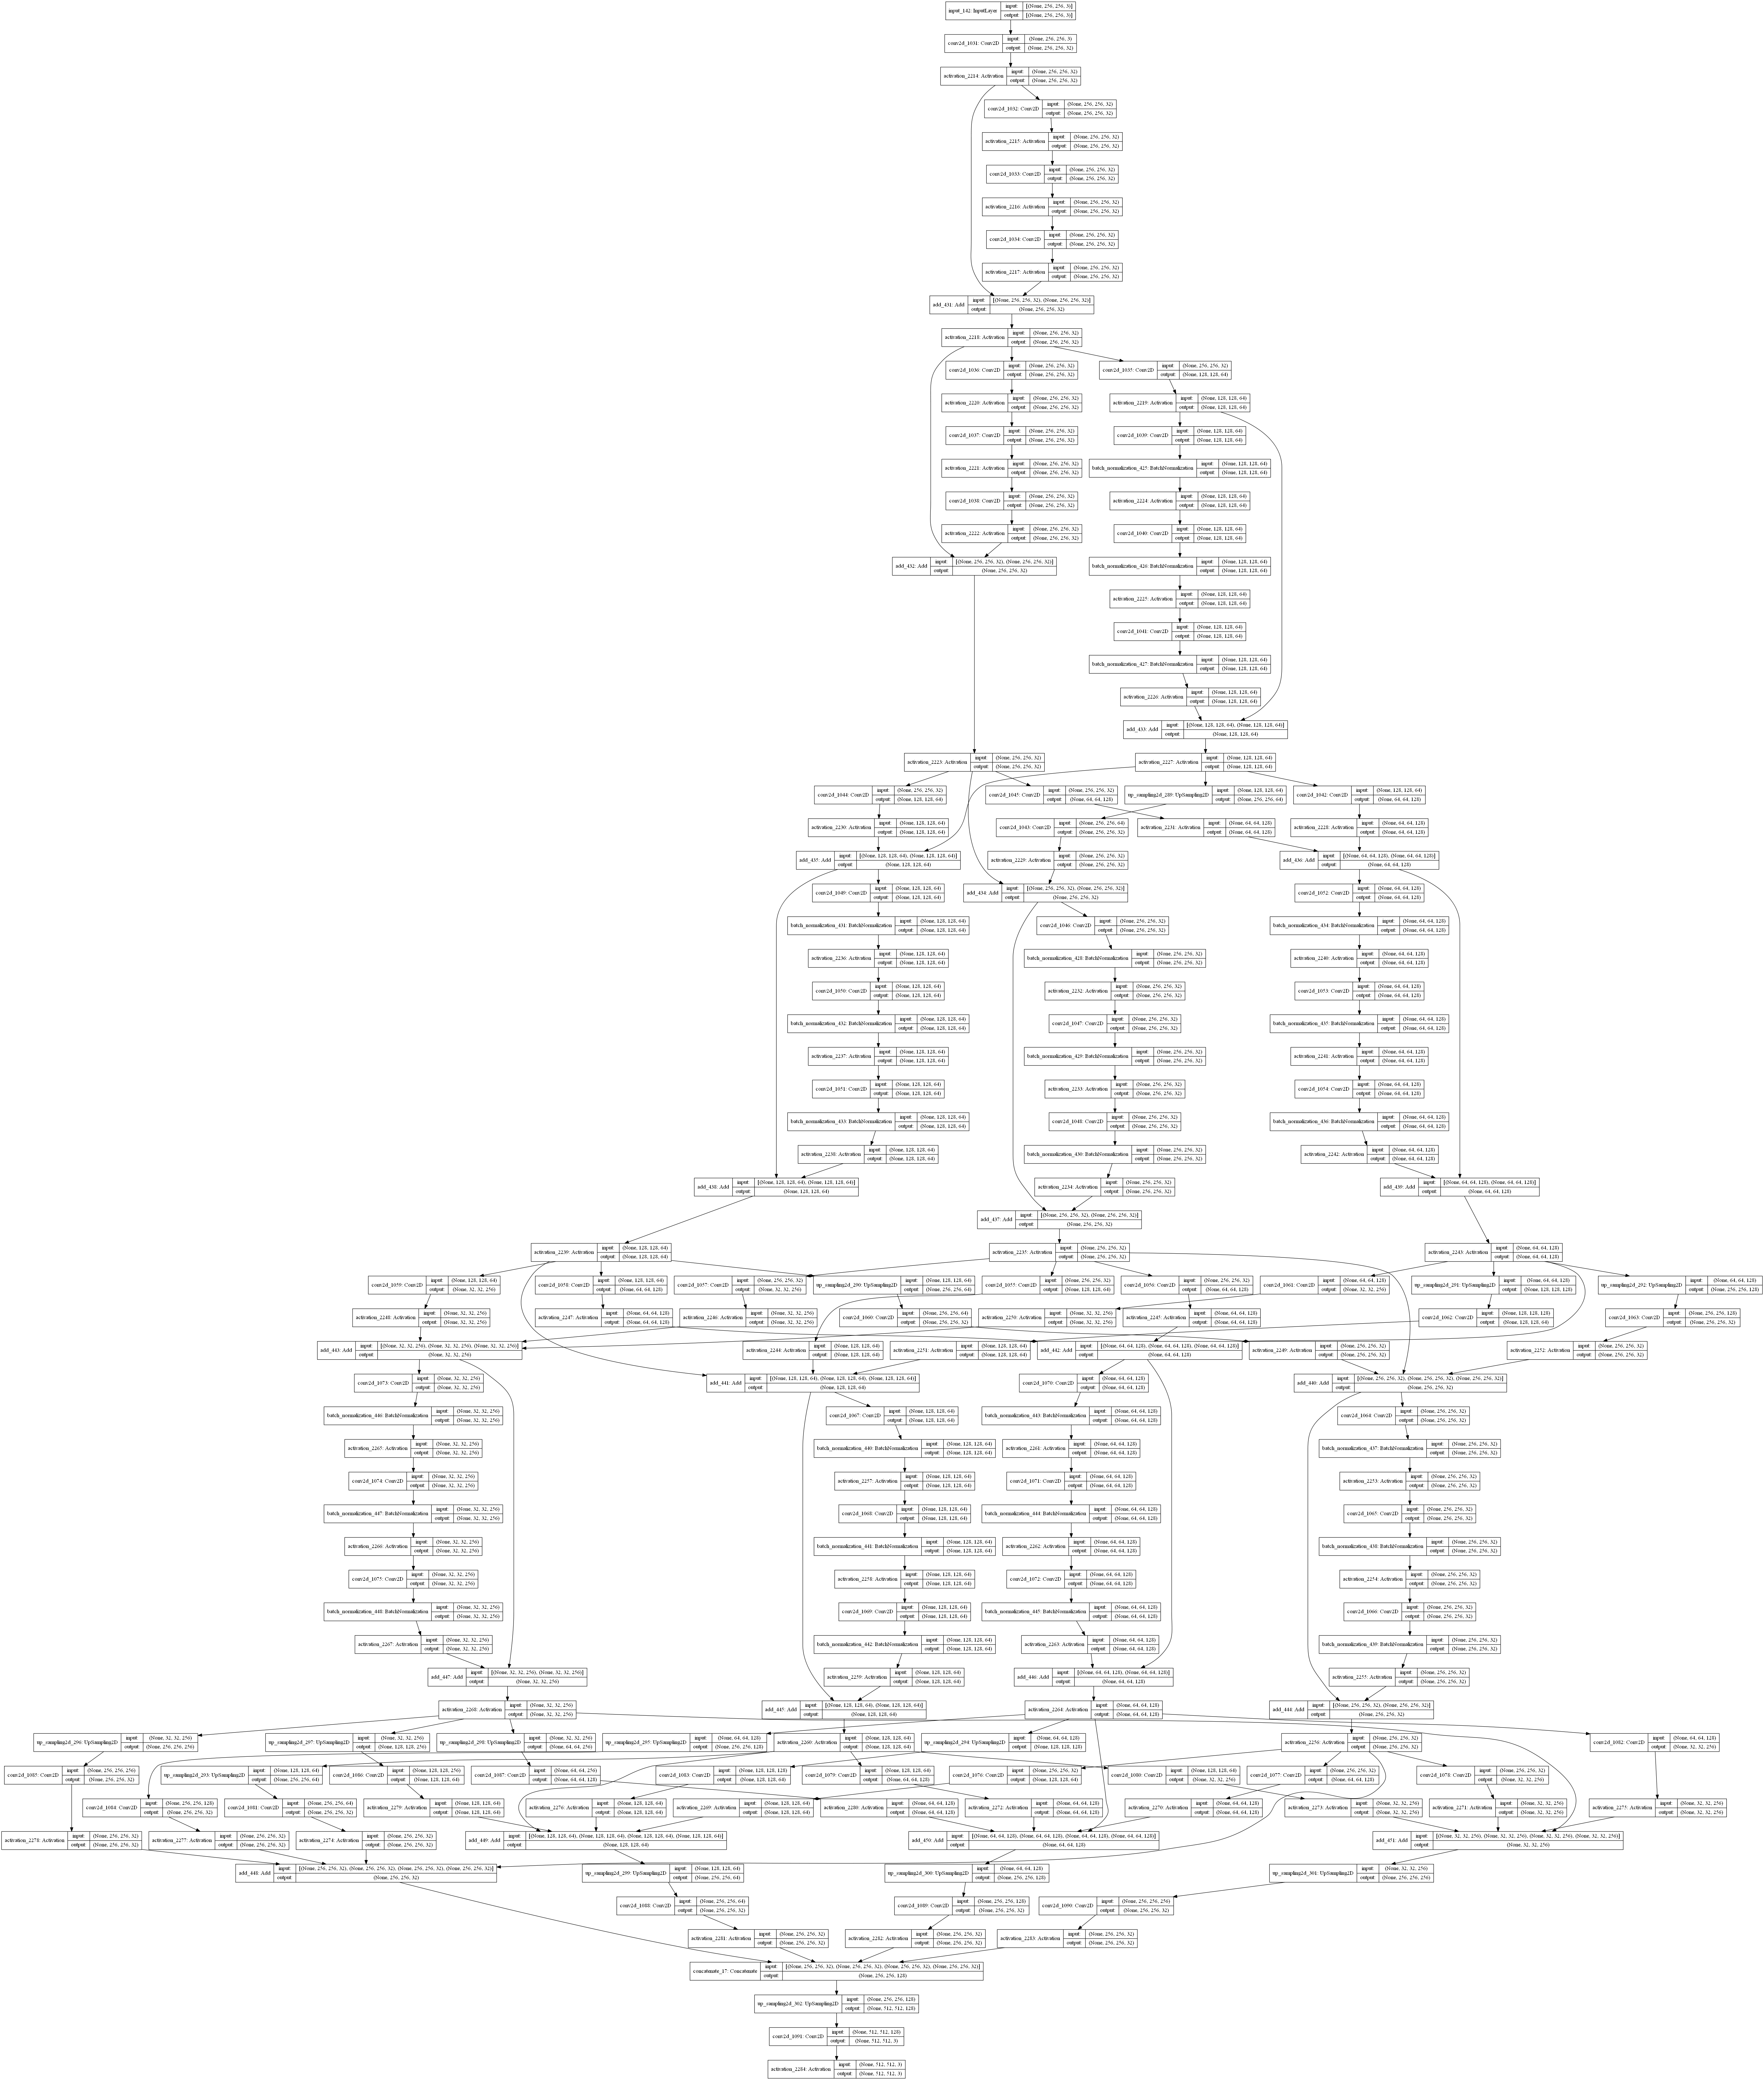

In [232]:

input_layer = Input(shape = (256,256,3))

x = resolution_block(input_layer,1,filters=32,kernel_size=3,add=False)

high_res1 = resolution_block(x,3,filters=32,kernel_size=3,name = 'res_256')
down_high_res1 = resolution_block(high_res1,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128',add = False)

high_res2 = resolution_block(high_res1,3,filters=32,kernel_size=3,name ='res2_256')
low1_res1 = resolution_block(down_high_res1,3,filters=64,kernel_size=3,name = 'res_128',batch_norm=True)


down_low1_res1 = resolution_block(low1_res1,1,filters=128,kernel_size=3,strides=2,name = 'down_128_64',add = False)
up_low1_res1 = transition_up(low1_res1,32,256)

down_256_128 = resolution_block(high_res2,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128_2',add = False)
down_256_64 = resolution_block(high_res2,1,filters=128,kernel_size=3,strides=4,name = 'down_256_64',add = False)



add1 = Add()([up_low1_res1,high_res2])
add2 = Add()([down_256_128,low1_res1])
add3 = Add()([down_256_64,down_low1_res1])


res256_3 = resolution_block(add1,3,filters=32,kernel_size=3,name= 'res3_256',batch_norm=True)
res128_2 = resolution_block(add2,3,filters=64,kernel_size=3,name= 'res2_128',batch_norm=True)
res64_1  = resolution_block(add3,3,filters=128,kernel_size=3,name= 'res1_64',batch_norm=True)

# connections from 265 resolutional block
down_256_128_3 = resolution_block(res256_3,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128_3',add = False)
down_256_64_3 = resolution_block(res256_3,1,filters=128,kernel_size=3,strides=4,name = 'down_256_64_3',add = False)
down_256_32_3 = resolution_block(res256_3,1,filters=256,kernel_size=3,strides=8,name = 'down_256_32_3',add = False)

# connections from 128 resolutional block
down_128_64_2 = resolution_block(res128_2,1,filters=128,kernel_size=3,strides=2,name='down_128_64_2',add = False)
down_128_32_2 = resolution_block(res128_2,1,filters=256,kernel_size=3,strides=4,name='down_128_32_2',add = False)
up_128_256_2 = transition_up(res128_2,32,256)

#connections from 64 resolutional block
down_64_32_1 = resolution_block(res64_1,1,filters=256,kernel_size=3,strides=2,name='down_64_32_1',add = False)
up_64_128_1 = transition_up(res64_1,64,128)
up_64_256_1 = transition_up(res64_1,32,256)

# additions of 3rd stage
add1_3 = Add()([res256_3,up_128_256_2,up_64_256_1])
add2_3 = Add()([res128_2,down_256_128_3,up_64_128_1])
add3_3 = Add()([res64_1,down_256_64_3,down_128_64_2])
add4_3 = Add()([down_256_32_3,down_128_32_2,down_64_32_1])


# 4th stage convolutions
res256_4 = resolution_block(add1_3,3,filters=32,kernel_size=3,name= 'res4_256',batch_norm=True)
res128_3 = resolution_block(add2_3,3,filters=64,kernel_size=3,name= 'res3_128',batch_norm=True)
res64_2  = resolution_block(add3_3,3,filters=128,kernel_size=3,name= 'res2_64',batch_norm=True)
res32_1  = resolution_block(add4_3,3,filters=256,kernel_size=3,name= 'res1_32',batch_norm=True)

# connections from 265 resolutional block
down_256_128_4 = resolution_block(res256_4,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128_4',add = False)
down_256_64_4 = resolution_block(res256_4,1,filters=128,kernel_size=3,strides=4,name = 'down_256_64_4',add = False)
down_256_32_4 = resolution_block(res256_4,1,filters=256,kernel_size=3,strides=8,name = 'down_256_32_4',add = False)

# connections from 128 resolutional block
down_128_64_3 = resolution_block(res128_3,1,filters=128,kernel_size=3,strides=2,name='down_128_64_3',add = False)
down_128_32_3 = resolution_block(res128_3,1,filters=256,kernel_size=3,strides=4,name='down_128_32_3',add = False)
up_128_256_3 = transition_up(res128_3,32,256)

#connections from 64 resolutional block
down_64_32_2 = resolution_block(res64_2,1,filters=256,kernel_size=3,strides=2,name='down_64_32_2',add = False)
up_64_128_2 = transition_up(res64_2,64,128)
up_64_256_2 = transition_up(res64_2,32,256)

#connections from 32 resolutional block
up_32_256_1 = transition_up(res32_1,32,256)
up_32_128_1 = transition_up(res32_1,64,128)
up_32_64_1 = transition_up(res32_1,128,64)

# additions of 4rd stage
add1_4 = Add()([res256_4,up_128_256_3,up_64_256_2,up_32_256_1])
add2_4 = Add()([res128_3,down_256_128_4,up_64_128_2,up_32_128_1])
add3_4 = Add()([res64_2,down_256_64_4,down_128_64_3,up_32_64_1])
add4_4 = Add()([res32_1,down_256_32_4,down_128_32_3,down_64_32_2])


# representation layer
up_32_256_f = transition_up(add2_4,32,256)
up_64_256_f = transition_up(add3_4,32,256)
up_128_256_f = transition_up(add4_4,32,256)

concat = Concatenate()([add1_4,up_128_256_f,up_64_256_f,up_32_256_f])
classify = transition_up(concat,3,512,activation='softmax')


#down_128_64_2 = resolution_block(res128_2,1,filters= 128,kernel_size=3,strides=2)

model = Model(inputs = input_layer,outputs= [classify])


plot_model(model,show_shapes = True)

In [239]:

input_layer = Input(shape = (256,256,3))

x = resolution_block(input_layer,1,filters=32,kernel_size=3,add=False)

high_res1 = create_n_blocks(3,x,3,32,3,name = 'res_256')
down_high_res1 = resolution_block(high_res1,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128',add = False)

high_res2 = create_n_blocks(3,high_res1,3,32,3,name ='res2_256')
low1_res1 = create_n_blocks(3,down_high_res1,3,64,3,name = 'res_128',batch_norm=True)


down_low1_res1 = resolution_block(low1_res1,1,filters=128,kernel_size=3,strides=2,name = 'down_128_64',add = False)
up_low1_res1 = transition_up(low1_res1,32,256)

down_256_128 = resolution_block(high_res2,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128_2',add = False)
down_256_64 = resolution_block(high_res2,1,filters=128,kernel_size=3,strides=4,name = 'down_256_64',add = False)



add1 = Add()([up_low1_res1,high_res2])
add2 = Add()([down_256_128,low1_res1])
add3 = Add()([down_256_64,down_low1_res1])


res256_3 = create_n_blocks(3,add1,3,32,3,name= 'res3_256',batch_norm=True)
res128_2 = create_n_blocks(3,add2,3,64,3,name= 'res2_128',batch_norm=True)
res64_1  = create_n_blocks(3,add3,3,128,3,name= 'res1_64',batch_norm=True)

# connections from 265 resolutional block
down_256_128_3 = resolution_block(res256_3,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128_3',add = False)
down_256_64_3 = resolution_block(res256_3,1,filters=128,kernel_size=3,strides=4,name = 'down_256_64_3',add = False)
down_256_32_3 = resolution_block(res256_3,1,filters=256,kernel_size=3,strides=8,name = 'down_256_32_3',add = False)

# connections from 128 resolutional block
down_128_64_2 = resolution_block(res128_2,1,filters=128,kernel_size=3,strides=2,name='down_128_64_2',add = False)
down_128_32_2 = resolution_block(res128_2,1,filters=256,kernel_size=3,strides=4,name='down_128_32_2',add = False)
up_128_256_2 = transition_up(res128_2,32,256)

#connections from 64 resolutional block
down_64_32_1 = resolution_block(res64_1,1,filters=256,kernel_size=3,strides=2,name='down_64_32_1',add = False)
up_64_128_1 = transition_up(res64_1,64,128)
up_64_256_1 = transition_up(res64_1,32,256)

# additions of 3rd stage
add1_3 = Add()([res256_3,up_128_256_2,up_64_256_1])
add2_3 = Add()([res128_2,down_256_128_3,up_64_128_1])
add3_3 = Add()([res64_1,down_256_64_3,down_128_64_2])
add4_3 = Add()([down_256_32_3,down_128_32_2,down_64_32_1])


# 4th stage convolutions
res256_4 = create_n_blocks(3,add1_3,3,32,3,name= 'res4_256',batch_norm=True)
res128_3 = create_n_blocks(3,add2_3,3,64,3,name= 'res3_128',batch_norm=True)
res64_2  = create_n_blocks(3,add3_3,3,128,3,name= 'res2_64',batch_norm=True)
res32_1  = create_n_blocks(3,add4_3,3,256,3,name= 'res1_32',batch_norm=True)

# connections from 265 resolutional block
down_256_128_4 = resolution_block(res256_4,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128_4',add = False)
down_256_64_4 = resolution_block(res256_4,1,filters=128,kernel_size=3,strides=4,name = 'down_256_64_4',add = False)
down_256_32_4 = resolution_block(res256_4,1,filters=256,kernel_size=3,strides=8,name = 'down_256_32_4',add = False)

# connections from 128 resolutional block
down_128_64_3 = resolution_block(res128_3,1,filters=128,kernel_size=3,strides=2,name='down_128_64_3',add = False)
down_128_32_3 = resolution_block(res128_3,1,filters=256,kernel_size=3,strides=4,name='down_128_32_3',add = False)
up_128_256_3 = transition_up(res128_3,32,256)

#connections from 64 resolutional block
down_64_32_2 = resolution_block(res64_2,1,filters=256,kernel_size=3,strides=2,name='down_64_32_2',add = False)
up_64_128_2 = transition_up(res64_2,64,128)
up_64_256_2 = transition_up(res64_2,32,256)

#connections from 32 resolutional block
up_32_256_1 = transition_up(res32_1,32,256)
up_32_128_1 = transition_up(res32_1,64,128)
up_32_64_1 = transition_up(res32_1,128,64)

# additions of 4rd stage
add1_4 = Add()([res256_4,up_128_256_3,up_64_256_2,up_32_256_1])
add2_4 = Add()([res128_3,down_256_128_4,up_64_128_2,up_32_128_1])
add3_4 = Add()([res64_2,down_256_64_4,down_128_64_3,up_32_64_1])
add4_4 = Add()([res32_1,down_256_32_4,down_128_32_3,down_64_32_2])


# representation layer
up_32_256_f = transition_up(add2_4,32,256)
up_64_256_f = transition_up(add3_4,32,256)
up_128_256_f = transition_up(add4_4,32,256)

concat = Concatenate()([add1_4,up_128_256_f,up_64_256_f,up_32_256_f])
classify = transition_up(concat,3,512,activation='softmax')


#down_128_64_2 = resolution_block(res128_2,1,filters= 128,kernel_size=3,strides=2)

model = Model(inputs = input_layer,outputs= [classify])


plot_model(model,show_shapes = True)

In [240]:
model.summary()

Model: "model_92"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_146 (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1277 (Conv2D)            (None, 256, 256, 32) 896         input_146[0][0]                  
__________________________________________________________________________________________________
activation_2511 (Activation)    (None, 256, 256, 32) 0           conv2d_1277[0][0]                
__________________________________________________________________________________________________
conv2d_1278 (Conv2D)            (None, 256, 256, 32) 9248        activation_2511[0][0]            
___________________________________________________________________________________________